In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import data_construction as dc
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
clean_data = 'cleaned_full_data.csv'

# import data
df = pd.read_csv(clean_data, index_col=0)

# interpolate and join
test = dc.det_interp(df.iloc[:,1])
econ_interp = df.iloc[:,:-1].apply(dc.det_interp, axis=0)
df = pd.concat([econ_interp, df.iloc[:,-1]], axis=1, join="outer")

# perform time lags
df['SVENY10_1'] = df['SVENY10'].shift(1)
df['SVENY10_60'] = df['SVENY10'].shift(60)
df_lag_1 = df.iloc[:,:-1].dropna().drop(['SVENY10'], axis=1)
df_lag_60 = df.drop(['SVENY10_1', 
    'SVENY10'], axis=1).dropna()
df = df.iloc[:,:-2]

In [34]:
df_pca = df.iloc[:, :-1]
pca = PCA(n_components=1)
pca.fit(df_pca)
df_pca = pd.DataFrame(pca.transform(df_pca), index=df.index)
df_pca['SVENY10'] =  df['SVENY10']

In [41]:
timestep = 2

def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(timestep, len(dataset)):
    a = dataset[i-timestep:i, 1:]
    dataX.append(a)
    dataY.append(dataset[i, 1:])
  return np.array(dataX), np.array(dataY)

dataset = np.array(df_pca)
scaler=MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

training_size=int(len(dataset)*0.95)
test_size=len(dataset)-training_size
train_data,test_data=dataset[0:training_size, :],dataset[training_size:len(dataset), :]

X_train, y_train = create_dataset(train_data, timestep)
X_test, y_test = create_dataset(test_data, timestep)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [42]:
def LSTM_Model():
  # model = Sequential()
  # model.add(LSTM(50, activation='relu', return_sequences=True, return_state=True))
  # model.add(Dense(1))

  input_layer = Input(shape=(timestep,1))
  lstm_1 = LSTM(50)(input_layer)
  dropout_1 = Dropout(0.2)(lstm_1)

  # lstm_2 = LSTM(50, return_sequences=True)(dropout_1)
  # dropout_2 = Dropout(0.2)(lstm_2)

  # lstm_3 = LSTM(50)(dropout_2)
  # dropout_3 = Dropout(0.2)(lstm_3)

  dense = Dense(1, activation='relu')(dropout_1)

  x = Dense(1, activation='linear')(dense)
  model = Model(inputs=input_layer, outputs=x)
  return model

In [43]:
model = LSTM_Model()
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, verbose=2, validation_split=0.1, batch_size=timestep)

Epoch 1/50
2993/2993 - 9s - loss: 0.0035 - val_loss: 3.3264e-04
Epoch 2/50
2993/2993 - 6s - loss: 7.0714e-04 - val_loss: 5.7617e-04
Epoch 3/50
2993/2993 - 6s - loss: 5.6067e-04 - val_loss: 3.7838e-04
Epoch 4/50
2993/2993 - 7s - loss: 4.7472e-04 - val_loss: 1.9884e-04
Epoch 5/50
2993/2993 - 6s - loss: 4.7666e-04 - val_loss: 1.5154e-04
Epoch 6/50
2993/2993 - 7s - loss: 5.2166e-04 - val_loss: 2.1094e-04
Epoch 7/50
2993/2993 - 6s - loss: 4.9084e-04 - val_loss: 1.7401e-04
Epoch 8/50
2993/2993 - 7s - loss: 4.6304e-04 - val_loss: 5.2891e-04
Epoch 9/50
2993/2993 - 6s - loss: 4.5072e-04 - val_loss: 1.6402e-04
Epoch 10/50
2993/2993 - 6s - loss: 4.6989e-04 - val_loss: 5.2007e-04
Epoch 11/50
2993/2993 - 7s - loss: 4.5583e-04 - val_loss: 1.9565e-04
Epoch 12/50
2993/2993 - 7s - loss: 4.6791e-04 - val_loss: 1.4795e-04
Epoch 13/50
2993/2993 - 6s - loss: 4.5587e-04 - val_loss: 2.9247e-04
Epoch 14/50
2993/2993 - 6s - loss: 4.4778e-04 - val_loss: 1.5959e-04
Epoch 15/50
2993/2993 - 7s - loss: 4.6566e-04 -

In [44]:
yhat = model.predict(X_test)

In [45]:
print(mean_squared_error(yhat,y_test))
# print(X_train.shape)

0.00030923092481234435


In [116]:
print(y_train.shape)

(6593,)


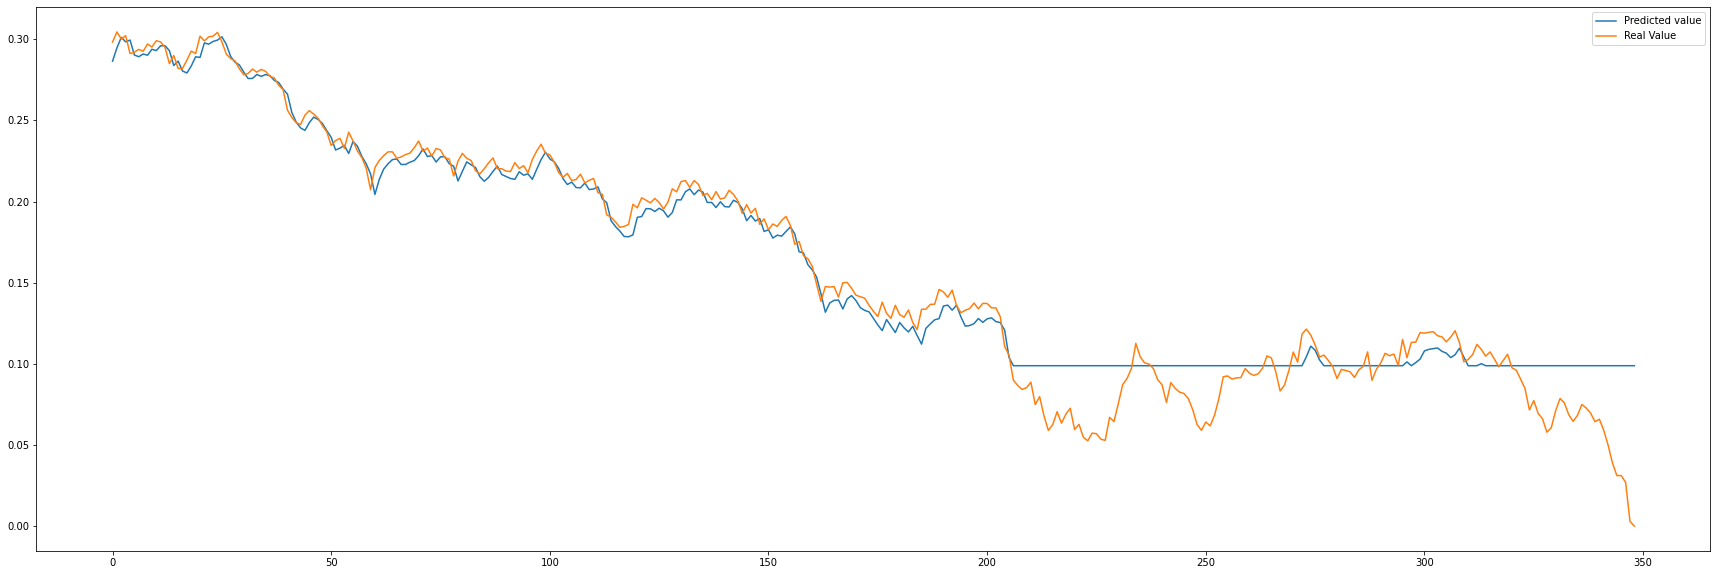

In [46]:
plt.figure(figsize=(30,10))
plt.plot(yhat)
plt.plot(y_test)
plt.legend(['Predicted value', 'Real Value'], loc='upper right')
plt.show()